In [1]:
import gc
import os
from pathlib import Path
import random
import sys
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.core.display import display, HTML
# --- models ---
from sklearn import preprocessing
from sklearn.model_selection import KFold
import torch

# --- setup ---
pd.set_option('max_columns', 50)
import dataclasses
import os
import sys
from pathlib import Path

import numpy as np
import pandas as pd
import pytorch_pfn_extras.training.extensions as E
import torch
from ignite.engine import Events
from pytorch_pfn_extras.training import IgniteExtensionsManager
from sklearn.model_selection import StratifiedKFold
from torch import nn, optim
from torch.utils.data.dataloader import DataLoader

from dataclasses import dataclass, field
from typing import Dict, Any, Tuple, Union, List
import dataclasses

fail to import amp_C: apex was not installed or installed without --cpp_ext.


In [2]:
from module import *

In [3]:
@dataclass
class Flags:
    # General
    debug: bool = True
    outdir: str = "results/det"
    device: str = "cuda:1"

    # Data config
    imgdir_name: str = "vinbigdata-chest-xray-resized-png-256x256"
    # split_mode: str = "all_train"  # all_train or valid20
    seed: int = 111
    target_fold: int = 0  # 0~4
    label_smoothing: float = 0.0
    # Model config
    model_name: str = "efficientnet_b8"
    model_mode: str = "normal"  # normal, cnn_fixed supported
    # Training config
    epoch: int = 20
    batchsize: int = 8
    valid_batchsize: int = 16
    num_workers: int = 4
    snapshot_freq: int = 5
    ema_decay: float = 0.999  # negative value is to inactivate ema.
    scheduler_type: str = ""
    scheduler_kwargs: Dict[str, Any] = field(default_factory=lambda: {})
    scheduler_trigger: List[Union[int, str]] = field(default_factory=lambda: [1, "iteration"])
    aug_kwargs: Dict[str, Dict[str, Any]] = field(default_factory=lambda: {})
    mixup_prob: float = -1.0  # Apply mixup augmentation when positive value is set.

    def update(self, param_dict: Dict) -> "Flags":
        # Overwrite by `param_dict`
        for key, value in param_dict.items():
            if not hasattr(self, key):
                raise ValueError(f"[ERROR] Unexpected key for flag = {key}")
            setattr(self, key, value)
        return self
    
    def to_yaml(self, filepath: str, width: int = 120):
        with open(filepath, 'w') as f:
            yaml.dump(asdict(self), f, width=width)

In [4]:
base_dir = Path().resolve()
base_dir

PosixPath('/home/kentaro123/vinbig/waka_vin/src')

In [7]:
def my_makedirs(path):
    if not os.path.isdir(path):
        print("make_dir")
        os.makedirs(path)

In [8]:
model_name_memo = "resnest50d"
my_makedirs("../../data/results_"+model_name_memo+"/")

make_dir


In [9]:
# パラメータ設定
flags_dict = {
    "debug": False,  # Change to True for fast debug run!
    "outdir": "../../data/results_"+model_name_memo+"/",
    # Data
    "imgdir_name": "../../data/",
    # Model
    "model_name": model_name_memo,
    # Training
    "num_workers": 4,
    "epoch": 20,
    "batchsize": 8,
    "scheduler_type": "CosineAnnealingWarmRestarts",
    "scheduler_kwargs": {"T_0": 28125},  # 15000 * 15 epoch // (batchsize=8)
    "scheduler_trigger": [1, "iteration"],
    "aug_kwargs": {
        "HorizontalFlip": {"p": 0.5},
        "ShiftScaleRotate": {"scale_limit": 0.15, "rotate_limit": 10, "p": 0.5},
        "RandomBrightnessContrast": {"p": 0.5},
        "CoarseDropout": {"max_holes": 8, "max_height": 25, "max_width": 25, "p": 0.5},
        "Blur": {"blur_limit": [3, 7], "p": 0.5},
        "Downscale": {"scale_min": 0.25, "scale_max": 0.9, "p": 0.3},
        "RandomGamma": {"gamma_limit": [80, 120], "p": 0.6},
    }
}

In [10]:
print("torch", torch.__version__)
flags = Flags().update(flags_dict)
print("flags", flags)
debug = flags.debug
outdir = Path(flags.outdir)
os.makedirs(str(outdir), exist_ok=True)
flags_dict = dataclasses.asdict(flags)
save_yaml(str(outdir / "flags.yaml"), flags_dict)

# --- Read data ---
inputdir = base_dir
datadir = inputdir / flags.imgdir_name
imgdir = inputdir / flags.imgdir_name

# Read in the data CSV files
train = pd.read_csv(datadir / "train.csv")
# sample_submission = pd.read_csv(datadir / 'sample_submission.csv')
dataset_dicts = get_vinbigdata_dicts(imgdir, train, debug=debug)


torch 1.7.1
flags Flags(debug=False, outdir='../../data/results_resnest50d/', device='cuda:1', imgdir_name='../../data/', seed=111, target_fold=0, label_smoothing=0.0, model_name='resnest50d', model_mode='normal', epoch=20, batchsize=8, valid_batchsize=16, num_workers=4, snapshot_freq=5, ema_decay=0.999, scheduler_type='CosineAnnealingWarmRestarts', scheduler_kwargs={'T_0': 28125}, scheduler_trigger=[1, 'iteration'], aug_kwargs={'HorizontalFlip': {'p': 0.5}, 'ShiftScaleRotate': {'scale_limit': 0.15, 'rotate_limit': 10, 'p': 0.5}, 'RandomBrightnessContrast': {'p': 0.5}, 'CoarseDropout': {'max_holes': 8, 'max_height': 25, 'max_width': 25, 'p': 0.5}, 'Blur': {'blur_limit': [3, 7], 'p': 0.5}, 'Downscale': {'scale_min': 0.25, 'scale_max': 0.9, 'p': 0.3}, 'RandomGamma': {'gamma_limit': [80, 120], 'p': 0.6}}, mixup_prob=-1.0)
Load from cache dataset_dicts_cache_original_debug0.pkl


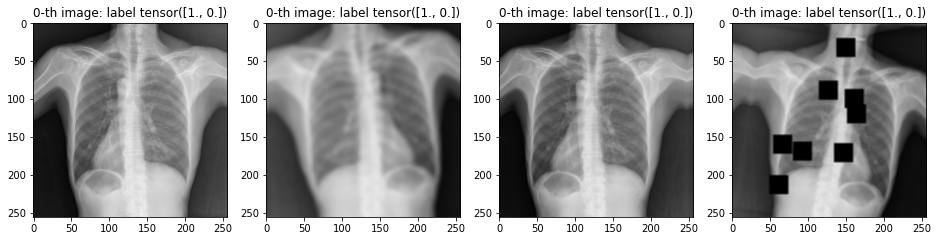

In [11]:
# ランダムにもとのデータを拡張したものが選ばれる
# data_autの確認
aug_dataset = VinbigdataTwoClassDataset(dataset_dicts, image_transform=Transform(flags.aug_kwargs))
index = 0

n_images = 4

fig, axes = plt.subplots(1, n_images, figsize=(16, 5))
for i in range(n_images):
    # Each time the data is accessed, the result is different due to random augmentation!
    img, label = aug_dataset[index]
    ax = axes[i]
    ax.imshow(img.cpu().numpy().transpose((1, 2, 0)) / 255.)
    ax.set_title(f"{index}-th image: label {label}")
plt.show()

Now creating the dataset is just easy as following:

<a id="model"></a>
# Defining CNN models

Recently, several libraries of CNN-collection are available on public.

I will use `timm` this time. You don't need to impelment deep CNN models by yourself, you can just re-use latest research results without hustle.<br/>
You can focus on more about looking data and try experiment now.

In [12]:
supported_models = timm.list_models()
print(f"{len(supported_models)} models are supported in timm.")
print(supported_models)

347 models are supported in timm.
['adv_inception_v3', 'cspdarknet53', 'cspdarknet53_iabn', 'cspresnet50', 'cspresnet50d', 'cspresnet50w', 'cspresnext50', 'cspresnext50_iabn', 'darknet53', 'densenet121', 'densenet121d', 'densenet161', 'densenet169', 'densenet201', 'densenet264', 'densenet264d_iabn', 'densenetblur121d', 'dla34', 'dla46_c', 'dla46x_c', 'dla60', 'dla60_res2net', 'dla60_res2next', 'dla60x', 'dla60x_c', 'dla102', 'dla102x', 'dla102x2', 'dla169', 'dpn68', 'dpn68b', 'dpn92', 'dpn98', 'dpn107', 'dpn131', 'eca_vovnet39b', 'ecaresnet18', 'ecaresnet50', 'ecaresnet50d', 'ecaresnet50d_pruned', 'ecaresnet101d', 'ecaresnet101d_pruned', 'ecaresnetlight', 'ecaresnext26tn_32x4d', 'efficientnet_b0', 'efficientnet_b1', 'efficientnet_b1_pruned', 'efficientnet_b2', 'efficientnet_b2_pruned', 'efficientnet_b2a', 'efficientnet_b3', 'efficientnet_b3_pruned', 'efficientnet_b3a', 'efficientnet_b4', 'efficientnet_b5', 'efficientnet_b6', 'efficientnet_b7', 'efficientnet_b8', 'efficientnet_cc_b0_4e'

Wow more than 300 models are supported!<br/>
It of course includes **resnet** related models, **efficientnet**, etc.<br/>
You may wonder which model should be used?<br/>
I will go with `resnet18` as a baseline at first, and try using more deeper/latest models in the experiment.

<a id="trainscript"></a>
# Training scripts

In [13]:
# 5fold validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=flags.seed)
y = np.array([int(len(d["annotations"]) > 0) for d in dataset_dicts])
split_inds = list(skf.split(dataset_dicts, y)) # dataset_dictsから生成
train_inds, valid_inds = split_inds[flags.target_fold]  # 0th fold
train_dataset = VinbigdataTwoClassDataset(
    [dataset_dicts[i] for i in train_inds],
    image_transform=Transform(flags.aug_kwargs),
    mixup_prob=flags.mixup_prob,
    label_smoothing=flags.label_smoothing,
)
valid_dataset = VinbigdataTwoClassDataset([dataset_dicts[i] for i in valid_inds])

In [14]:
# datasetなど定義
train_loader = DataLoader(
    train_dataset,
    batch_size=flags.batchsize,
    num_workers=flags.num_workers,
    shuffle=True,
    pin_memory=True,
)
valid_loader = DataLoader(
    valid_dataset,
    batch_size=flags.valid_batchsize,
    num_workers=flags.num_workers,
    shuffle=False,
    pin_memory=True,
)

device = torch.device(flags.device)

predictor = build_predictor(model_name=flags.model_name, model_mode=flags.model_mode)
classifier = Classifier(predictor)
model = classifier
# optimizer = optim.Adam(model.parameters(), lr=1e-3)
optimizer = optim.Adam([param for param in model.parameters() if param.requires_grad], lr=1e-3)

# Train setup
trainer = create_trainer(model, optimizer, device)

ema = EMA(predictor, decay=flags.ema_decay)

def eval_func(*batch):
    loss, metrics = model(*[elem.to(device) for elem in batch])
    # HACKING: report ema value with prefix.
    if flags.ema_decay > 0:
        classifier.prefix = "ema_"
        ema.assign()
        loss, metrics = model(*[elem.to(device) for elem in batch])
        ema.resume()
        classifier.prefix = ""

valid_evaluator = E.Evaluator(
    valid_loader, model, progress_bar=False, eval_func=eval_func, device=device
)

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-resnest/resnest50-528c19ca.pth" to /home/kentaro123/.cache/torch/hub/checkpoints/resnest50-528c19ca.pth


In [ ]:

# log_trigger = (10 if debug else 1000, "iteration")
log_trigger = (1, "epoch")
log_report = E.LogReport(trigger=log_trigger)
extensions = [
    log_report,
    E.ProgressBarNotebook(update_interval=10 if debug else 100),  # Show progress bar during training
    E.PrintReportNotebook(),  # Show "log" on jupyter notebook  
    # E.ProgressBar(update_interval=10 if debug else 100),  # Show progress bar during training
    # E.PrintReport(),  # Print "log" to terminal
    E.FailOnNonNumber(),  # Stop training when nan is detected.
]
epoch = flags.epoch
models = {"main": model}
optimizers = {"main": optimizer}
manager = IgniteExtensionsManager(
    trainer, models, optimizers, epoch, extensions=extensions, out_dir=str(outdir),
)
# Run evaluation for valid dataset in each epoch.
manager.extend(valid_evaluator)

# Save predictor.pt every epoch
manager.extend(
    E.snapshot_object(predictor, "predictor.pt"), trigger=(flags.snapshot_freq, "epoch")
)
# Check & Save best validation predictor.pt every epoch
# manager.extend(E.snapshot_object(predictor, "best_predictor.pt"),
#                trigger=MinValueTrigger("validation/module/nll",
#                trigger=(flags.snapshot_freq, "iteration")))

# --- lr scheduler ---
if flags.scheduler_type != "":
    scheduler_type = flags.scheduler_type
    print(f"using {scheduler_type} scheduler with kwargs {flags.scheduler_kwargs}")
    manager.extend(
        LRScheduler(optimizer, scheduler_type, flags.scheduler_kwargs),
        trigger=flags.scheduler_trigger,
    )

manager.extend(E.observe_lr(optimizer=optimizer), trigger=log_trigger)

if flags.ema_decay > 0:
    # Exponential moving average
    manager.extend(lambda manager: ema(), trigger=(1, "iteration"))

    def save_ema_model(manager):
        ema.assign()
        torch.save(predictor.state_dict(), outdir / "predictor_ema.pt")
        ema.resume()

    manager.extend(save_ema_model, trigger=(flags.snapshot_freq, "epoch"))

_ = trainer.run(train_loader, max_epochs=epoch)

using CosineAnnealingWarmRestarts scheduler with kwargs {'T_0': 28125}


HTML(value='')

So what is happening in above training abstraction? Let's understand what each extension did.

**Extensions** - Each role:
 - **`ProgressBar` (`ProgressBarNotebook`)**: Shows training progress in formatted style.
 - **`LogReport`**: Logging metrics reported by `ppe.reporter.report` (see `LyftMultiRegressor` for reporting point) method and save to **log** file. It automatically collects reported value in each iteration and saves the "mean" of reported value for regular frequency (for example every 1 epoch).
 - **`PrintReport` (`PrintReportNotebook`)**: Prints the value which `LogReport` collected in formatted style.
 - **`Evaluator`**: Evaluate on validation dataset.
 - **`snapshot_object`**: Saves the object. Here the `model` is saved in regular interval `flags.snapshot_freq`. Even you quit training using Ctrl+C without finishing all the epoch, the intermediate trained model is saved and you can use it for inference.
 - **`LRScheduler`**: You can insert learning rate scheduling with this extension, together with the regular interval call specified by `trigger`. Here cosine annealing is applied (configured by Flags) by calling `scheduler.step()` every iteration.
 - **`observe_lr`**: `LogReport` will check optimizer's learning rate using this extension. So you can follow how the learning rate changed through the training.


Such many functionalities can be "added" easily using extensions!

Also **Exponential Moving Average of model weights** is calculated by `EMA` class during training, together with showing its validation loss. We can usually obtrain more stable models with EMA.

You can obtrain training history results really easily by just accessing `LogReport` class, which is useful for managing a lot of experiments during kaggle competitions.

In [34]:
torch.save(predictor.state_dict(), outdir / "predictor_last.pt")
df = log_report.to_dataframe()
df.to_csv(outdir / "log.csv", index=False)
df

,main/loss,main/acc,validation/main/loss,validation/main/acc,validation/main/ema_loss,validation/main/ema_acc,lr,epoch,iteration,elapsed_time
0,0.540290,0.819167,0.262506,0.902926,0.213135,0.911237,0.000993,1,1500,171.466353
1,0.308306,0.871000,0.223423,0.914229,0.221412,0.910572,0.000972,2,3000,325.903006
2,0.279861,0.884833,0.204104,0.915559,0.327251,0.885306,0.000938,3,4500,499.995694
3,0.267133,0.888917,0.201222,0.928191,0.267537,0.886968,0.000892,4,6000,673.472633
4,0.244779,0.901417,0.222588,0.915559,0.350969,0.846742,0.000835,5,7500,838.183470
5,0.233133,0.907333,0.185026,0.922872,0.292672,0.909242,0.000768,6,9000,1012.588425
6,0.218923,0.914167,0.174581,0.936503,0.249616,0.914229,0.000694,7,10500,1187.947124
7,0.195573,0.918417,0.158647,0.937832,0.178971,0.933843,0.000614,8,12000,1361.388785
8,0.186458,0.925167,0.205545,0.916888,0.157403,0.938497,0.000531,9,13500,1533.690829
9,0.166870,0.933417,0.162027,0.940492,0.154114,0.939495,0.000448,10,15000,1699.354319


<a id="prediction"></a>
# Prediction on validation & test dataset

In [35]:
# --- Prediction ---
print("Training done! Start prediction...")
# valid data
valid_pred = classifier.predict_proba(valid_loader).cpu().numpy()
valid_pred_df = pd.DataFrame({
    "image_id": [dataset_dicts[i]["image_id"] for i in valid_inds],
    "class0": valid_pred[:, 0],
    "class1": valid_pred[:, 1]
})
valid_pred_df.to_csv(outdir/"valid_pred.csv", index=False)

# test data
test_meta = pd.read_csv(inputdir / "../../data" / "test_meta.csv")
dataset_dicts_test = get_vinbigdata_dicts_test(imgdir, test_meta, debug=debug)
test_dataset = VinbigdataTwoClassDataset(dataset_dicts_test, train=False)
test_loader = DataLoader(
    test_dataset,
    batch_size=flags.valid_batchsize,
    num_workers=flags.num_workers,
    shuffle=False,
    pin_memory=True,
)
test_pred = classifier.predict_proba(test_loader).cpu().numpy()
test_pred_df = pd.DataFrame({
    "image_id": [d["image_id"] for d in dataset_dicts_test],
    "class0": test_pred[:, 0],
    "class1": test_pred[:, 1]
})
test_pred_df.to_csv(outdir/"test_pred.csv", index=False)

Training done! Start prediction...
Load from cache dataset_dicts_cache_test_debug0.pkl


In [36]:
# --- Test dataset prediction result ---
test_pred_df

,image_id,class0,class1
0,8dec5497ecc246766acfba5a4be4e619,0.999999,7.755958e-07
1,287422bed1d9d153387361889619abed,0.961340,3.866021e-02
2,1d12b94b7acbeadef7d7700b50aa90d4,0.999759,2.407542e-04
3,6b872791e23742f6c33a08fc24f77365,0.970897,2.910336e-02
4,d0d2addff91ad7beb1d92126ff74d621,0.999995,5.397857e-06
...,...,...,...
2995,78b44b96b121d6075d7ae27135278e03,0.999999,9.102185e-07
2996,afee8ff90f29b8827d0eb78774d25324,0.999998,2.117764e-06
2997,6e07fab2014be723250f7897ab6e3df2,0.996857,3.142978e-03
2998,690bb572300ef08bbbb7ebf4196099cf,0.997173,2.826942e-03


/home/kentaro123/anaconda3/envs/vinbig/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/kentaro123/anaconda3/envs/vinbig/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


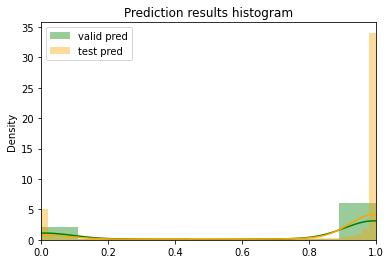

In [37]:
sns.distplot(valid_pred_df["class0"].values, color='green', label='valid pred')
sns.distplot(test_pred_df["class0"].values, color='orange', label='test pred')
plt.title("Prediction results histogram")
plt.xlim([0., 1.])
plt.legend()

# Apply 2 class filter on detection prediction

I will use detection prediction from the kernel:
 - [📸VinBigData detectron2 train](https://www.kaggle.com/corochann/vinbigdata-detectron2-train)
 - [📸VinBigData detectron2 prediction](https://www.kaggle.com/corochann/vinbigdata-detectron2-prediction)

And 2class prediction is updated as dataset: [vinbigdata-2class-pred](https://www.kaggle.com/corochann/vinbigdata2classpred).

As mentioned in [VinBigData 🌟2 Class Filter🌟](https://www.kaggle.com/awsaf49/vinbigdata-2-class-filter) by @awsaf49, applying 2-class filter improves LB score significantly. (Please upvote his kernel as well!)<br/>
Also, it is mentioned that we can submit **14 prob 1 1 0 0** where the `prob` is the normal probability in the discussion [[Scoring bug] Improve your LB score by 0.053, just adding "14 1 0 0 1 1"](https://www.kaggle.com/c/vinbigdata-chest-xray-abnormalities-detection/discussion/211971)!

Here, I will propose new post processing (similar to [this](https://www.kaggle.com/c/vinbigdata-chest-xray-abnormalities-detection/discussion/211971#1157809) by @pestipeti):

Here `p` is the **normal probability**.

1. `p < low_threshold`                   -> Do nothing, Keep det prediction.
2. `low_threshold <= p < high_threshold` -> Just "Add" Normal prediction, **keep** detection prediction.
3. `high_threshold <= p`                 -> Replace with Normal prediction with normal score 1.0, **remove** all detection predictoin.


[Note] I also wrote another kernel to train 2-class model: [📸VinBigData 2-class classifier complete pipeline](https://www.kaggle.com/corochann/vinbigdata-2-class-classifier-complete-pipeline) to train these 2-class classifier model!

In [38]:
# pred_2class = pd.read_csv(inputdir/"vinbigdata-2class-prediction/2-cls test pred.csv")  # LB 0.230
# low_threshold = 0.0
# high_threshold = 0.95

pred_2class = pd.read_csv(inputdir/"../../data/vinbigdata2classpred/test_pred.csv")
low_threshold = 0.0
high_threshold = 0.976
pred_2class

,image_id,class0,class1
0,8dec5497ecc246766acfba5a4be4e619,0.976988,0.023012
1,287422bed1d9d153387361889619abed,0.950402,0.049598
2,1d12b94b7acbeadef7d7700b50aa90d4,0.995952,0.004048
3,6b872791e23742f6c33a08fc24f77365,0.874948,0.125052
4,d0d2addff91ad7beb1d92126ff74d621,0.997519,0.002481
...,...,...,...
2995,78b44b96b121d6075d7ae27135278e03,0.991775,0.008225
2996,afee8ff90f29b8827d0eb78774d25324,0.998331,0.001669
2997,6e07fab2014be723250f7897ab6e3df2,0.990037,0.009963
2998,690bb572300ef08bbbb7ebf4196099cf,0.975643,0.024356


In [39]:
NORMAL = "14 1 0 0 1 1"

pred_det_df = pd.read_csv(inputdir/"../../data/submission.csv")  # You can load from another submission.csv here too.
n_normal_before = len(pred_det_df.query("PredictionString == @NORMAL"))
merged_df = pd.merge(pred_det_df, pred_2class, on="image_id", how="left")

# 1. p < low_threshold                   -> "Keep": Do nothing, Keep det prediction.
# 2. low_threshold <= p < high_threshold -> "Add": Just "Add" Normal prediction
# 3. high_threshold <= p                 -> "Replace": Replace with Normal prediction

if "target" in merged_df.columns:
    merged_df["class0"] = 1 - merged_df["target"]

c0, c1, c2 = 0, 0, 0
for i in range(len(merged_df)):
    p0 = merged_df.loc[i, "class0"]
    if p0 < low_threshold:
        # Keep, do nothing.
        c0 += 1
    elif low_threshold <= p0 and p0 < high_threshold:
        # Add, keep "det" preds and add normal pred.
        merged_df.loc[i, "PredictionString"] += f" 14 {p0} 0 0 1 1"
        c1 += 1
    else:
        # Replace, remove all "det" preds.
        merged_df.loc[i, "PredictionString"] = NORMAL
        c2 += 1

n_normal_after = len(merged_df.query("PredictionString == @NORMAL"))
print(
    f"n_normal: {n_normal_before} -> {n_normal_after} with threshold {low_threshold} & {high_threshold}"
)
print(f"Keep {c0} Add {c1} Replace {c2}")
submission_filepath = str(outdir / "submission.csv")
submission_df = merged_df[["image_id", "PredictionString"]]
submission_df.to_csv(submission_filepath, index=False)
print(f"Saved to {submission_filepath}")

n_normal: 3000 -> 1713 with threshold 0.0 & 0.976
Keep 0 Add 1287 Replace 1713
Saved to ../../data/results/submission.csv
